In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

In [72]:
group1 = pd.read_csv('group1.csv')
group1_stn = list(group1['stn'].values)
stn1 = []
for v in group1_stn:
    if v not in stn1:
        stn1.append(v)
print(stn1)

[105, 112, 115, 108]


In [73]:
group2 = pd.read_csv('group2.csv')
group2_stn = list(group2['stn'].values)
stn2 = []
for v in group2_stn:
    if v not in stn2:
        stn2.append(v)
print(stn2)

[131, 132, 133, 138, 152, 156, 159, 165, 143, 146]


In [74]:
group3 = pd.read_csv('group3.csv')
group3_stn = list(group3['stn'].values)
stn3 = []
for v in group3_stn:
    if v not in stn3:
        stn3.append(v)
print(stn3)

[13]


In [75]:
train1 = pd.read_csv('./uv_train_cloud.csv')


In [76]:
train1['rainfall'].isnull().sum()

1509402

In [77]:
train1 = train1.drop(['rainfall'], axis=1)


In [78]:
group1_stn = list(train1['stn'].values)
stn1 = []
for v in group1_stn:
    if v not in stn1:
        stn1.append(v)
print(stn1)

[13, 105, 108, 112, 115, 131, 132, 133, 138, 143, 146, 152, 156, 159, 165]


In [79]:
##13, 132 따로

In [80]:
# stn1 = [105, 108, 112, 115, 131, 133, 
#         138, 143, 146, 152, 156, 159, 165]
stn1 = [105, 112, 115, 108]
stn2 = [131, 133, 138, 152, 156, 159, 165, 143, 146]
stn3 = [13, 132]

uv_train1 = train1[train1['stn'].isin(stn1)]
uv_train2 = train1[train1['stn'].isin(stn2)]
uv_train3 = train1[train1['stn'].isin(stn3)]

In [81]:
train1.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'lon', 'lat', 'uv', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10',
       'band11', 'band12', 'band13', 'band14', 'band15', 'band16', 'solarza',
       'sateza', 'esr', 'height', 'landtype', 'total_cloud', 'ml_cloud'],
      dtype='object')

In [83]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [84]:
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

In [ ]:
#### STN 위에서 나눈 대로 잘라서 돌릴 것!!!!!!!!!!!!!!!!

In [ ]:
from optuna.samplers import TPESampler

###stn1 train set
train1 = train1.drop(['total_cloud', 'ml_cloud'], axis=1)


uv_train1_val = train1[(train1['yyyymmdd'] >= 20210601) & (uv_train1['yyyymmdd'] < 20210701)]
idx1 = uv_train1_val.index
all_group1 = uv_train1.drop(train1.index[idx1])

X = all_group1[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
Y = all_group1['uv']

x = uv_train1_val[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
y = uv_train1_val['uv']

X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.3, random_state=123)

X_train1 = pd.concat([X,X_train1])
y_train1 = pd.concat([Y,y_train1])




sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(X_train1, label=y_train1)
    dtest = lgb.Dataset(X_test1, label=y_test1)

    param = {

        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',6, 15),
        "num_leaves": trial.suggest_int("num_leaves", 31, 1000),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 6000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9)
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train1, y_train1, eval_set=[(X_test1, y_test1)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_test1, lgb_model.predict(X_test1))
    return rmse
        
study_lgb1 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb1.optimize(objective, n_trials=100)

[I 2022-07-29 16:43:10,198] A new study created in memory with name: no-name-b902a4bc-c014-4bca-b9a2-466f75427ef3
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 16:43:23,725] Trial 0 finished with value: 0.5868079409143541 and parameters: {'max_depth': 13, 'num_leaves': 51, 'learning_rate': 0.0018505314477536697, 'n

[I 2022-07-29 16:45:56,288] Trial 7 finished with value: 1.2520283082968733 and parameters: {'max_depth': 7, 'num_leaves': 411, 'learning_rate': 0.00015378739805285157, 'n_estimators': 5106, 'min_child_samples': 19, 'subsample': 0.5687409490746276, 'colsample_bytree': 0.8888521424477602}. Best is trial 4 with value: 0.5593194220672886.
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated a

[I 2022-07-29 16:49:31,418] Trial 15 finished with value: 0.5850421246342711 and parameters: {'max_depth': 13, 'num_leaves': 781, 'learning_rate': 0.0005027929543370913, 'n_estimators': 6000, 'min_child_samples': 82, 'subsample': 0.8093309607955524, 'colsample_bytree': 0.7645242990198389}. Best is trial 12 with value: 0.5545553644850578.
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated

[I 2022-07-29 16:58:41,063] Trial 23 finished with value: 0.5527761719322233 and parameters: {'max_depth': 12, 'num_leaves': 902, 'learning_rate': 0.0015458384736540844, 'n_estimators': 5424, 'min_child_samples': 5, 'subsample': 0.7295710586420036, 'colsample_bytree': 0.8177722480737601}. Best is trial 21 with value: 0.5492853160025084.
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated 

[I 2022-07-29 17:07:36,661] Trial 31 finished with value: 0.5487587409739443 and parameters: {'max_depth': 13, 'num_leaves': 919, 'learning_rate': 0.0019060462866880546, 'n_estimators': 5258, 'min_child_samples': 6, 'subsample': 0.7322531609584801, 'colsample_bytree': 0.8209216254554089}. Best is trial 31 with value: 0.5487587409739443.
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated 

In [ ]:
###stn2 train set
train2 = train2.drop(['total_cloud', 'ml_cloud'], axis=1)


uv_train2_val = train2[(train2['yyyymmdd'] >= 20210601) & (uv_train2['yyyymmdd'] < 20210701)]
idx2 = uv_train2_val.index
all_group2 = uv_train2.drop(train2.index[idx2])

X = all_group2[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
Y = all_group2['uv']

x = uv_train2_val[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
y = uv_train2_val['uv']

X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.3, random_state=123)

X_train2 = pd.concat([X,X_train2])
y_train2 = pd.concat([Y,y_train2])

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(X_train2, label=y_train2)
    dtest = lgb.Dataset(X_test2, label=y_test2)

    param = {

        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',6, 15),
        "num_leaves": trial.suggest_int("num_leaves", 31, 1000),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 6000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9)
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_test2, lgb_model.predict(X_test2))
    return rmse
        
study_lgb2 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb2.optimize(objective, n_trials=100)

In [ ]:
###stn3 train set
train3 = train3.drop(['total_cloud', 'ml_cloud'], axis=1)


uv_train3_val = train3[(train3['yyyymmdd'] >= 20210601) & (uv_train3['yyyymmdd'] < 20210701)]
idx3 = uv_train3_val.index
all_group3 = uv_train3.drop(train3.index[idx3])

X = all_group3[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
Y = all_group3['uv']

x = uv_train3_val[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
y = uv_train3_val['uv']

X_train3, X_test3, y_train3, y_test3 = train_test_split(x, y, test_size=0.3, random_state=123)

X_train3 = pd.concat([X,X_train3])
y_train3 = pd.concat([Y,y_train3])

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(X_train3, label=y_train3)
    dtest = lgb.Dataset(X_test3, label=y_test3)

    param = {

        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',6, 15),
        "num_leaves": trial.suggest_int("num_leaves", 31, 1000),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 6000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9)
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train3, y_train3, eval_set=[(X_test3, y_test3)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_test3, lgb_model.predict(X_test3))
    return rmse
        
study_lgb3 = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb3.optimize(objective, n_trials=100)

In [ ]:
trial1 = study_lgb1.best_trial
trial_params1 = trial1.params
print('Best Trial: score {},\nparams {}'.format(trial1.value, trial_params1))

final_lgb_model1 = lgb.LGBMRegressor(**trial_params1)
final_lgb_model1.fit(X_train1, y_train1)
final_lgb_pred1 = final_lgb_model1.predict(X_test1)
print(final_lgb_pred1)

plt.barh(X_train1.columns, final_lgb_model1.feature_importances_)

In [ ]:
trial2 = study_lgb2.best_trial
trial_params2 = trial2.params
print('Best Trial: score {},\nparams {}'.format(trial2.value, trial_params2))

final_lgb_model2 = lgb.LGBMRegressor(**trial_params2)
final_lgb_model2.fit(X_train2, y_train2)
final_lgb_pred2 = final_lgb_model2.predict(X_test2)
print(final_lgb_pred2)

plt.barh(X_train2.columns, final_lgb_model2.feature_importances_)

In [ ]:
trial3 = study_lgb3.best_trial
trial_params3 = trial3.params
print('Best Trial: score {},\nparams {}'.format(trial3.value, trial_params3))

final_lgb_model3 = lgb.LGBMRegressor(**trial_params3)
final_lgb_model3.fit(X_train3, y_train3)
final_lgb_pred3 = final_lgb_model3.predict(X_test3)
print(final_lgb_pred3)

plt.barh(X_train3.columns, final_lgb_model3.feature_importances_)

In [63]:
# all_inter = pd.DataFrame()
# for i in stn1:
#     inter = uv_train1[uv_train1['stn'].isin([i])]
#     inter = inter.interpolate(method ='linear') 
#     all_inter = pd.concat([all_inter, inter])
    

In [64]:
# uv_train1 = all_inter.sort_index()


In [65]:
# uv_train1 = uv_train1.interpolate(method ='linear') 

In [66]:
uv_train1

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band14,band15,band16,solarza,sateza,esr,height,landtype,total_cloud,ml_cloud
1,20200101,0,105,128.89098,37.75147,0.0,-0.00057,0.00057,0.00030,-0.00030,...,268.41686,268.01723,256.99670,163.20549,43.95463,-9.40930,26.04,3,0.0,0.0
2,20200101,0,108,126.96500,37.57100,0.0,0.00000,0.00000,-0.00089,-0.00075,...,258.18692,257.58363,250.50021,162.48279,43.77999,-9.37761,85.50,3,9.0,9.0
3,20200101,0,112,126.62490,37.47772,0.0,-0.00057,-0.00057,-0.00060,0.00015,...,258.64012,258.03883,251.00820,162.39995,43.67046,-9.37422,68.99,3,9.0,9.0
4,20200101,0,115,130.89864,37.48129,0.0,0.00000,-0.00057,-0.00030,0.00075,...,263.95472,262.33534,253.25397,164.19725,43.74521,-9.45200,222.80,4,7.0,7.0
16,20200101,10,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00045,...,268.53498,268.08594,256.90085,164.12129,43.95463,-9.40930,26.04,3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533586,20211231,2340,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00119,-0.00015,...,264.20253,263.47143,253.27381,162.03995,43.74521,-9.00798,222.80,4,9.0,9.0
1533598,20211231,2350,105,128.89098,37.75147,0.0,-0.00057,-0.00057,-0.00060,0.00000,...,263.45704,263.13011,253.51155,162.07968,43.95463,-8.90375,26.04,3,2.0,0.0
1533599,20211231,2350,108,126.96500,37.57100,0.0,0.00000,-0.00057,0.00030,-0.00030,...,262.99242,262.84181,253.23413,161.20883,43.77999,-8.81055,85.50,3,0.0,0.0
1533600,20211231,2350,112,126.62490,37.47772,0.0,-0.00057,0.00000,-0.00089,0.00015,...,267.67097,267.10261,255.66655,161.09608,43.67046,-8.79549,68.99,3,3.0,0.0


In [13]:
# uv_train2 = uv_train2.drop(['total_cloud','ml_cloud'], axis=1)


In [14]:
# uv_train2.isnull().sum()

yyyymmdd    0
hhnn        0
stn         0
lon         0
lat         0
uv          0
band1       0
band2       0
band3       0
band4       0
band5       0
band6       0
band7       0
band8       0
band9       0
band10      0
band11      0
band12      0
band13      0
band14      0
band15      0
band16      0
solarza     0
sateza      0
esr         0
height      0
landtype    0
dtype: int64

In [68]:
# uv_train2

In [70]:
uv_train1_val = uv_train1[(uv_train1['yyyymmdd'] >= 20210601) & (uv_train1['yyyymmdd'] < 20210701)]
idx1 = uv_train1_val.index
all_group1 = uv_train1.drop(uv_train1.index[idx1])

X = all_group1[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height','total_cloud','ml_cloud']]
Y = all_group1['uv']

x = uv_train1_val[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height','total_cloud','ml_cloud']]
y = uv_train1_val['uv']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

X_train = pd.concat([X,X_train])
y_train = pd.concat([Y,y_train])




IndexError: index 1081632 is out of bounds for axis 0 with size 406988

In [10]:
import seaborn as sns

In [11]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
X_train.info()
y_train.info()
X_test.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313980 entries, 1 to 1140646
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   hhnn         1313980 non-null  int64  
 1   band1        1313980 non-null  float64
 2   band2        1313980 non-null  float64
 3   band3        1313980 non-null  float64
 4   band7        1313980 non-null  float64
 5   band11       1313980 non-null  float64
 6   band12       1313980 non-null  float64
 7   band13       1313980 non-null  float64
 8   solarza      1313980 non-null  float64
 9   esr          1313980 non-null  float64
 10  height       1313980 non-null  float64
 11  total_cloud  1313980 non-null  float64
 12  ml_cloud     1313980 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 140.3 MB
<class 'pandas.core.series.Series'>
Int64Index: 1313980 entries, 1 to 1140646
Series name: uv
Non-Null Count    Dtype  
--------------    -----  
1313980 non-null  float64
dt

In [ ]:

colsample_bytree=0.9
max_depth = 7
n_estimators = 4000             # 400  #1000
lr = 0.02                     # 0.017
num_leaves = 511
early_stopping_rounds = 100      # 100
verbose = False   


lgbm_reg = LGBMRegressor(objective= "regression",
                     colsample_bytree = colsample_bytree,
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)

lgbm_reg.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric=["rmse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 

In [12]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest = lgb.Dataset(X_test, label=y_test)

    param = {

        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',6, 15),
        "num_leaves": trial.suggest_int("num_leaves", 31, 1000),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 6000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9)
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_test, lgb_model.predict(X_test))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-07-29 11:15:57,203] A new study created in memory with name: no-name-8e92ada5-7d8f-4f7a-bec8-25666da2d597
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-29 11:19:21,627] Trial 0 finished with value: 0.5506722962126299 and parameters: {'max_depth': 13, 'num_leaves': 1188, 'learning_rate': 0.001850531

[I 2022-07-29 11:34:20,416] Trial 7 finished with value: 1.2727147836733927 and parameters: {'max_depth': 7, 'num_leaves': 4154, 'learning_rate': 0.00015378739805285157, 'n_estimators': 5106, 'min_child_samples': 19, 'subsample': 0.5687409490746276, 'colsample_bytree': 0.8888521424477602}. Best is trial 4 with value: 0.5501441570159628.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is

[I 2022-07-29 11:46:57,198] Trial 15 finished with value: 0.5515907383175953 and parameters: {'max_depth': 9, 'num_leaves': 6993, 'learning_rate': 0.00671446321487449, 'n_estimators': 4091, 'min_child_samples': 84, 'subsample': 0.4928889781061034, 'colsample_bytree': 0.7314077878016134}. Best is trial 11 with value: 0.5486874484173067.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is 

[I 2022-07-29 12:05:46,797] Trial 23 finished with value: 0.5481100282268564 and parameters: {'max_depth': 12, 'num_leaves': 7269, 'learning_rate': 0.0034124068246147274, 'n_estimators': 5410, 'min_child_samples': 58, 'subsample': 0.46636186839398663, 'colsample_bytree': 0.7485115020988216}. Best is trial 21 with value: 0.5477187159519797.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument

[I 2022-07-29 12:51:40,000] Trial 31 finished with value: 0.5477463265796153 and parameters: {'max_depth': 12, 'num_leaves': 7196, 'learning_rate': 0.005081606560015477, 'n_estimators': 5018, 'min_child_samples': 56, 'subsample': 0.47918863956968966, 'colsample_bytree': 0.7449119209001478}. Best is trial 21 with value: 0.5477187159519797.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument 

[I 2022-07-29 13:10:08,368] Trial 39 finished with value: 0.5490459561446127 and parameters: {'max_depth': 14, 'num_leaves': 5628, 'learning_rate': 0.005086309247099096, 'n_estimators': 4820, 'min_child_samples': 61, 'subsample': 0.48773513583688155, 'colsample_bytree': 0.7430662611607077}. Best is trial 21 with value: 0.5477187159519797.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument 

In [45]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest = lgb.Dataset(X_test, label=y_test)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_test, lgb_model.predict(X_test))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-07-28 23:28:26,500] A new study created in memory with name: no-name-e540c7f7-8860-400a-9b5e-e05b998592f7
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:28:39,680] Trial 0 finished with value: 2.282604189992743 and parameters: {'max_depth': 13, 'learning_rate': 0.00011002817226254398, 'n_estim

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:29:55,500] Trial 8 finished with value: 0.6759579385567136 and parameters: {'max_depth': 10, 'learning_rate': 0.0043508488031796955, 'n_estimators': 478, 'min_child_samples': 87, 'subsample': 0.5520731753100153}. Best is trial 8 with value: 0.675957938556

[I 2022-07-28 23:31:49,488] Trial 16 finished with value: 0.5423403189600985 and parameters: {'max_depth': 13, 'learning_rate': 0.005297127609590053, 'n_estimators': 1981, 'min_child_samples': 43, 'subsample': 0.4037322308791715}. Best is trial 16 with value: 0.5423403189600985.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Ligh

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:34:14,407] Trial 25 finished with value: 0.5266846452030582 and parameters: {'max_depth': 9, 'learning_rate': 0.009657009839995498, 'n_estimators': 1715, 'min_child_samples': 6, 'subsample': 0.47680433020394963}. Best is trial 22 with value: 0.52147160824

[I 2022-07-28 23:36:06,903] Trial 33 finished with value: 0.5506981938706674 and parameters: {'max_depth': 11, 'learning_rate': 0.004625550783139468, 'n_estimators': 1847, 'min_child_samples': 5, 'subsample': 0.4508165834554608}. Best is trial 22 with value: 0.5214716082418841.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Light

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:38:19,269] Trial 42 finished with value: 0.5336865988105465 and parameters: {'max_depth': 11, 'learning_rate': 0.007710553933544465, 'n_estimators': 1716, 'min_child_samples': 19, 'subsample': 0.4500796472648804}. Best is trial 22 with value: 0.5214716082

[I 2022-07-28 23:40:15,110] Trial 50 finished with value: 0.5647983903510291 and parameters: {'max_depth': 14, 'learning_rate': 0.00413076207972142, 'n_estimators': 1467, 'min_child_samples': 49, 'subsample': 0.41248185926203224}. Best is trial 22 with value: 0.5214716082418841.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Ligh

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:42:35,112] Trial 59 finished with value: 0.5301174585578899 and parameters: {'max_depth': 13, 'learning_rate': 0.0082317666473781, 'n_estimators': 1763, 'min_child_samples': 26, 'subsample': 0.4139493469686168}. Best is trial 22 with value: 0.521471608241

[I 2022-07-28 23:44:32,484] Trial 67 finished with value: 0.5722687515958907 and parameters: {'max_depth': 8, 'learning_rate': 0.0037051083759212858, 'n_estimators': 1413, 'min_child_samples': 22, 'subsample': 0.5194709788219787}. Best is trial 22 with value: 0.5214716082418841.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Ligh

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:47:06,919] Trial 76 finished with value: 0.5395361597090803 and parameters: {'max_depth': 11, 'learning_rate': 0.005956436418024234, 'n_estimators': 1909, 'min_child_samples': 71, 'subsample': 0.4911939093981675}. Best is trial 72 with value: 0.5184938684

[I 2022-07-28 23:49:31,417] Trial 84 finished with value: 0.524210791601338 and parameters: {'max_depth': 13, 'learning_rate': 0.008675887439113546, 'n_estimators': 1954, 'min_child_samples': 68, 'subsample': 0.5804466216476378}. Best is trial 72 with value: 0.5184938684853763.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Light

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-07-28 23:52:07,608] Trial 93 finished with value: 1.2070023851043556 and parameters: {'max_depth': 12, 'learning_rate': 0.000457108525966519, 'n_estimators': 1901, 'min_child_samples': 59, 'subsample': 0.6074360403015646}. Best is trial 72 with value: 0.5184938684

In [46]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.5178388656678076,
params {'max_depth': 14, 'learning_rate': 0.009994761730516164, 'n_estimators': 1997, 'min_child_samples': 73, 'subsample': 0.622413509242086}


In [29]:

# colsample_bytree=0.9
# max_depth = 14
# n_estimators = 1997             # 400  #1000
# lr = 0.009994761730516164                     # 0.017
# num_leaves = 511
# early_stopping_rounds = 25      # 100
# verbose = False   
# min_child_samples =  73
# subsample =  0.6224

# lgbm_reg = LGBMRegressor(objective= "regression",
#                      colsample_bytree = colsample_bytree,
#                      max_depth= max_depth,
#                      n_estimators= n_estimators,
#                      learning_rate= lr,
#                      num_leaves = num_leaves,
#                      min_child_samples = min_child_samples,
#                      subsample = subsample   )

# lgbm_reg.fit(X_train, y_train,
#           eval_set=[(X_test, y_test)],
#           eval_metric=["rmse"],
#           early_stopping_rounds=early_stopping_rounds,
#           verbose=verbose) 

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.009994761730516164,
              max_depth=14, min_child_samples=73, n_estimators=1997,
              num_leaves=511, objective='regression', subsample=0.6224)

In [47]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest = lgb.Dataset(X_test, label=y_test)

    param = {
        'boosting_type': 'dart',
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(y_test, lgb_model.predict(X_test))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-07-28 23:55:02,020] A new study created in memory with name: no-name-21ea1a84-3cf2-4ea0-9d08-d8856e1432c4
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Ear

[I 2022-07-29 00:03:21,533] Trial 6 finished with value: 1.741988869728136 and parameters: {'max_depth': 13, 'learning_rate': 0.0011048270653924235, 'n_estimators': 1827, 'min_child_samples': 35, 'subsample': 0.4345676420333751}. Best is trial 6 with value: 1.741988869728136.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGB

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 00:12:00,797] Trial 13 finished with value: 1.1462918494586196 and parameters: {'max_depth': 15, 'learning_rate': 0.003840113884729365, 'n_estimators': 1124, 'min_child_samples': 53, 'subsample': 0.9492608512059212}. Best is trial 12 with value: 0.9602784867687729.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be re

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 00:26:21,206] Trial 20 finished with value: 0.7656175770872774 and parameters: {'max_depth': 12, 'learning_rate': 0.006382650490155244, 'n_estimators': 1337, 'min_child_samples': 25, 'subsample': 0.5105698151318672}. Best is trial 17 with value: 0.6702773298994291.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be re

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 00:41:33,731] Trial 27 finished with value: 0.6161761373368377 and parameters: {'max_depth': 8, 'learning_rate': 0.008068250390452109, 'n_estimators': 1818, 'min_child_samples': 14, 'subsample': 0.4350593560838514}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be rem

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 00:53:49,217] Trial 34 finished with value: 0.6635952215881542 and parameters: {'max_depth': 7, 'learning_rate': 0.007421491811986854, 'n_estimators': 1626, 'min_child_samples': 19, 'subsample': 0.48532168505969076}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be re

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 01:07:45,128] Trial 41 finished with value: 0.599757621576694 and parameters: {'max_depth': 10, 'learning_rate': 0.00971374506381552, 'n_estimators': 1731, 'min_child_samples': 11, 'subsample': 0.44786439518330085}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be rem

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 01:21:33,017] Trial 48 finished with value: 2.1228555072339224 and parameters: {'max_depth': 5, 'learning_rate': 0.0006430407185245744, 'n_estimators': 1909, 'min_child_samples': 38, 'subsample': 0.6217552035731969}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be re

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 01:33:09,552] Trial 55 finished with value: 0.6227842217485392 and parameters: {'max_depth': 11, 'learning_rate': 0.008075067290088715, 'n_estimators': 1778, 'min_child_samples': 18, 'subsample': 0.46073238042114845}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be r

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 01:45:32,838] Trial 62 finished with value: 0.5992657399876563 and parameters: {'max_depth': 9, 'learning_rate': 0.009049467370186137, 'n_estimators': 1820, 'min_child_samples': 9, 'subsample': 0.43721908229312473}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be rem

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 02:00:19,589] Trial 69 finished with value: 0.6112947412113143 and parameters: {'max_depth': 11, 'learning_rate': 0.009956646640743014, 'n_estimators': 1653, 'min_child_samples': 62, 'subsample': 0.40388479123533144}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be r

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 02:14:34,805] Trial 76 finished with value: 0.6810282145410204 and parameters: {'max_depth': 12, 'learning_rate': 0.005855831826549814, 'n_estimators': 1888, 'min_child_samples': 13, 'subsample': 0.4008323198407156}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be re

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 02:28:52,303] Trial 83 finished with value: 0.6018380022077651 and parameters: {'max_depth': 8, 'learning_rate': 0.009079969308273124, 'n_estimators': 1931, 'min_child_samples': 21, 'subsample': 0.4612184773020328}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be rem

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 02:40:27,475] Trial 90 finished with value: 0.6536185449144643 and parameters: {'max_depth': 11, 'learning_rate': 0.008757287478091798, 'n_estimators': 1418, 'min_child_samples': 17, 'subsample': 0.5011224869887854}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be re

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2022-07-29 02:54:52,752] Trial 97 finished with value: 0.6434077930195317 and parameters: {'max_depth': 12, 'learning_rate': 0.00686953442027685, 'n_estimators': 1907, 'min_child_samples': 7, 'subsample': 0.6593743451887798}. Best is trial 22 with value: 0.5887487828286446.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be remo

In [48]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.5887487828286446,
params {'max_depth': 12, 'learning_rate': 0.00992163826866627, 'n_estimators': 1852, 'min_child_samples': 45, 'subsample': 0.48011979989319653}


In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

In [ ]:

colsample_bytree=0.9
max_depth = 7
n_estimators = 4000             # 400  #1000
lr = 0.02                     # 0.017
num_leaves = 511
early_stopping_rounds = 100      # 100
verbose = False   


lgbm_reg = LGBMRegressor(objective= "regression",
                     colsample_bytree = colsample_bytree,
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)

lgbm_reg.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric=["rmse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 





In [21]:
sub = pd.read_csv('./uv_test_cloud.csv')

In [22]:
sub = sub.drop(['rainfall'], axis=1)

all_inter = pd.DataFrame()
for i in stn1:
    inter = sub[sub['stn'].isin([i])]
    inter = inter.interpolate(method ='linear') 
    all_inter = pd.concat([all_inter, inter])
    

In [23]:
sub1 = all_inter[all_inter['stn'].isin(stn1)]

In [24]:
sub1

,yyyymmdd,hhnn,stn,Lon,Lat,UV,Band1,Band2,Band3,Band4,...,Band14,Band15,Band16,SolarZA,SateZA,ESR,Height,LandType,total_cloud,ml_cloud
1,20220601,0,105,128.89098,37.75147,NaN,-0.00057,-0.00057,0.000000,-0.00030,...,261.145800,257.526580,246.95577,119.74915,43.95463,-4.61100,26.04,3,8.000000,0.0
16,20220601,10,105,128.89098,37.75147,NaN,-0.00057,-0.00057,0.000300,0.00030,...,263.135640,260.708670,249.80529,119.99587,43.95463,-4.61100,26.04,3,7.833333,0.0
31,20220601,20,105,128.89098,37.75147,NaN,-0.00057,0.00000,0.000187,0.00045,...,250.685579,249.017181,243.36946,120.15117,43.95463,-4.61100,26.04,3,7.666667,0.0
46,20220601,30,105,128.89098,37.75147,NaN,-0.00057,-0.00057,0.000890,-0.00015,...,244.416210,241.132400,234.91324,120.18497,43.95463,-4.61100,26.04,3,7.500000,0.0
61,20220601,40,105,128.89098,37.75147,NaN,-0.00057,-0.00057,-0.000600,0.00015,...,249.468530,246.545640,239.04355,120.06332,43.95463,-4.61100,26.04,3,7.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51794,20220624,2320,165,126.38121,34.81689,NaN,0.00000,0.00000,-0.000890,0.00000,...,290.095870,288.317840,273.42368,118.23785,40.67788,-4.16606,38.00,3,9.000000,9.0
51809,20220624,2330,165,126.38121,34.81689,NaN,-0.00057,0.00000,-0.000300,-0.00090,...,291.403550,289.257110,273.82366,118.98719,40.67788,-4.16606,38.00,3,9.000000,9.0
51824,20220624,2340,165,126.38121,34.81689,NaN,0.00000,-0.00057,-0.000300,-0.00030,...,291.322250,289.213910,273.75708,119.65269,40.67788,-4.16606,38.00,3,9.000000,9.0
51839,20220624,2350,165,126.38121,34.81689,NaN,0.00000,0.00000,0.000000,-0.00060,...,290.533410,288.636500,273.54047,120.23153,40.67788,-4.16606,38.00,3,9.000000,9.0


In [25]:
sub1.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'Lon', 'Lat', 'UV', 'Band1', 'Band2',
       'Band3', 'Band4', 'Band5', 'Band6', 'Band7', 'Band8', 'Band9', 'Band10',
       'Band11', 'Band12', 'Band13', 'Band14', 'Band15', 'Band16', 'SolarZA',
       'SateZA', 'ESR', 'Height', 'LandType', 'total_cloud', 'ml_cloud'],
      dtype='object')

In [26]:
preds =lgbm_reg.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("MSE: %f" % (mse))

sub1_test = sub1[['hhnn', 'Band1', 'Band2','Band3', 'Band7', 
       'Band11', 'Band12', 'Band13', 'SolarZA','ESR', 'Height','total_cloud', 'ml_cloud']]

pred1 =lgbm_reg.predict(sub1_test)

MSE: 0.145791


In [70]:
uv_train2_val = uv_train2[(uv_train2['yyyymmdd'] >= 20210601) & (uv_train2['yyyymmdd'] < 20210701)]
idx2 = uv_train2_val.index
all_group1 = uv_train2.drop(index=idx2)

X = all_group1[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
Y = all_group1['uv']

x = uv_train2_val[['hhnn','band1', 'band2','band3', 'band7',
       'band11', 'band12', 'band13', 'solarza','esr', 'height']]
y = uv_train2_val['uv']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

X_train = pd.concat([X,X_train])
y_train = pd.concat([Y,y_train])



colsample_bytree=0.9
max_depth = 7
n_estimators = 4000             # 400  #1000
lr = 0.02                     # 0.017
num_leaves = 511
early_stopping_rounds = 100      # 100
verbose = False   


lgbm_reg = LGBMRegressor(objective= "regression",
                     colsample_bytree = colsample_bytree,
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)

lgbm_reg.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric=["rmse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 





C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.02, max_depth=7,
              n_estimators=4000, num_leaves=511, objective='regression')

In [30]:
sub2 = sub[sub['stn'].isin(stn2)]
sub2

,yyyymmdd,hhnn,stn,Lon,Lat,UV,Band1,Band2,Band3,Band4,...,Band14,Band15,Band16,SolarZA,SateZA,ESR,Height,LandType,total_cloud,ml_cloud
0,20220601,0,13,126.16,33.30,NaN,0.00000,0.00000,-0.000600,0.000600,...,250.119130,248.786860,243.126010,123.72706,38.96359,-5.16304,71.0,0,NaN,NaN
6,20220601,0,132,126.33,36.54,NaN,0.00000,-0.00057,0.000000,0.000450,...,263.528310,261.442970,251.453170,120.59151,42.62037,-4.73492,47.0,0,NaN,NaN
15,20220601,10,13,126.16,33.30,NaN,-0.00057,0.00000,-0.000300,0.000750,...,245.689140,244.421340,239.842750,124.10999,38.96359,-5.16304,71.0,0,NaN,NaN
21,20220601,10,132,126.33,36.54,NaN,-0.00057,-0.00057,-0.000890,-0.000600,...,265.675300,263.525220,252.856460,120.94071,42.62037,-4.73492,47.0,0,NaN,NaN
30,20220601,20,13,126.16,33.30,NaN,-0.00057,0.00000,0.000244,0.000525,...,250.828489,249.120726,243.423005,124.39329,38.96359,-5.16304,71.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51816,20220624,2340,132,126.33,36.54,NaN,-0.00057,-0.00057,0.000000,0.000150,...,283.973190,281.238530,266.193310,118.00703,42.62037,-3.94212,47.0,0,NaN,NaN
51825,20220624,2350,13,126.16,33.30,NaN,0.00000,0.00000,-0.001190,-0.000450,...,292.750220,290.232680,274.122840,121.64697,38.96359,-4.34718,71.0,0,NaN,NaN
51831,20220624,2350,132,126.33,36.54,NaN,0.00000,-0.00057,0.000600,-0.000300,...,289.546580,287.064720,271.269150,118.56659,42.62037,-3.94212,47.0,0,NaN,NaN
51840,20220625,0,13,126.16,33.30,NaN,0.00000,0.00000,0.000300,-0.000300,...,291.105180,288.085610,272.468720,122.16167,38.96359,-4.91886,71.0,0,NaN,NaN


In [72]:
sub2.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'Lon', 'Lat', 'UV', 'Band1', 'Band2',
       'Band3', 'Band4', 'Band5', 'Band6', 'Band7', 'Band8', 'Band9', 'Band10',
       'Band11', 'Band12', 'Band13', 'Band14', 'Band15', 'Band16', 'SolarZA',
       'SateZA', 'ESR', 'Height', 'LandType', 'total_cloud', 'ml_cloud'],
      dtype='object')

In [31]:
preds =lgbm_reg.predict(X_test)
mse = mean_squared_error(y_test, preds)
print("MSE: %f" % (mse))

sub2_test = sub2[['hhnn', 'Band1', 'Band2','Band3', 'Band7', 
       'Band11', 'Band12', 'Band13', 'SolarZA','ESR', 'Height']]

pred2 =lgbm_reg.predict(sub2_test)

MSE: 0.300657


In [32]:
sub1['UV'] = pred1
sub2['UV'] = pred2


C:\Users\KMJ\AppData\Local\Temp\ipykernel_22640\2155818563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2['UV'] = pred2


In [33]:
pred_end = pd.concat([sub1,sub2])

In [34]:
pred_end

,yyyymmdd,hhnn,stn,Lon,Lat,UV,Band1,Band2,Band3,Band4,...,Band14,Band15,Band16,SolarZA,SateZA,ESR,Height,LandType,total_cloud,ml_cloud
1,20220601,0,105,128.89098,37.75147,0.000504,-0.00057,-0.00057,0.000000,-0.00030,...,261.145800,257.526580,246.95577,119.74915,43.95463,-4.61100,26.04,3,8.000000,0.0
16,20220601,10,105,128.89098,37.75147,0.000551,-0.00057,-0.00057,0.000300,0.00030,...,263.135640,260.708670,249.80529,119.99587,43.95463,-4.61100,26.04,3,7.833333,0.0
31,20220601,20,105,128.89098,37.75147,0.001144,-0.00057,0.00000,0.000187,0.00045,...,250.685579,249.017181,243.36946,120.15117,43.95463,-4.61100,26.04,3,7.666667,0.0
46,20220601,30,105,128.89098,37.75147,0.001786,-0.00057,-0.00057,0.000890,-0.00015,...,244.416210,241.132400,234.91324,120.18497,43.95463,-4.61100,26.04,3,7.500000,0.0
61,20220601,40,105,128.89098,37.75147,0.000581,-0.00057,-0.00057,-0.000600,0.00015,...,249.468530,246.545640,239.04355,120.06332,43.95463,-4.61100,26.04,3,7.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51816,20220624,2340,132,126.33000,36.54000,0.000940,-0.00057,-0.00057,0.000000,0.00015,...,283.973190,281.238530,266.19331,118.00703,42.62037,-3.94212,47.00,0,NaN,NaN
51825,20220624,2350,13,126.16000,33.30000,0.003454,0.00000,0.00000,-0.001190,-0.00045,...,292.750220,290.232680,274.12284,121.64697,38.96359,-4.34718,71.00,0,NaN,NaN
51831,20220624,2350,132,126.33000,36.54000,0.001789,0.00000,-0.00057,0.000600,-0.00030,...,289.546580,287.064720,271.26915,118.56659,42.62037,-3.94212,47.00,0,NaN,NaN
51840,20220625,0,13,126.16000,33.30000,0.003658,0.00000,0.00000,0.000300,-0.00030,...,291.105180,288.085610,272.46872,122.16167,38.96359,-4.91886,71.00,0,NaN,NaN


In [35]:
pred_=pred_end.sort_index(ascending=True)
pred_

,yyyymmdd,hhnn,stn,Lon,Lat,UV,Band1,Band2,Band3,Band4,...,Band14,Band15,Band16,SolarZA,SateZA,ESR,Height,LandType,total_cloud,ml_cloud
0,20220601,0,13,126.16000,33.30000,0.003579,0.00000,0.00000,-0.00060,0.00060,...,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0,NaN,NaN
1,20220601,0,105,128.89098,37.75147,0.000504,-0.00057,-0.00057,0.00000,-0.00030,...,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3,8.0,0.0
2,20220601,0,108,126.96500,37.57100,-0.000105,0.00000,-0.00057,-0.00030,0.00045,...,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3,7.0,0.0
3,20220601,0,112,126.62490,37.47772,0.001270,0.00000,0.00000,0.00060,0.00045,...,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3,6.0,0.0
4,20220601,0,115,130.89864,37.48129,-0.000767,0.00000,0.00000,0.00089,-0.00030,...,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0.022970,0.00000,-0.00057,-0.00089,0.00015,...,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3,8.0,8.0
51851,20220625,0,152,129.33472,35.58250,0.001063,-0.00057,0.00000,-0.00030,-0.00030,...,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2,0.0,0.0
51852,20220625,0,156,126.89158,35.17294,0.003665,0.00000,0.00000,0.00089,-0.00030,...,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3,6.0,6.0
51853,20220625,0,159,129.03203,35.10468,0.002741,0.00000,0.00057,0.00030,-0.00075,...,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3,8.0,8.0


In [36]:
submission = pd.read_csv('./1-1_검증데이터셋_수정.csv')

In [38]:
submission['UV']=pred_[['UV']]
submission

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.003579
1,202206010000,105,0.000504
2,202206010000,108,-0.000105
3,202206010000,112,0.001270
4,202206010000,115,-0.000767
...,...,...,...
51850,202206250000,146,0.022970
51851,202206250000,152,0.001063
51852,202206250000,156,0.003665
51853,202206250000,159,0.002741


<AxesSubplot:>

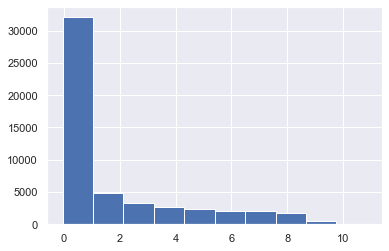

In [39]:
submission['UV'].hist()    

In [44]:
pred_hhnn = pred_.copy()

In [45]:
pred_hhnn.columns

Index(['yyyymmdd', 'hhnn', 'stn', 'Lon', 'Lat', 'UV', 'Band1', 'Band2',
       'Band3', 'Band4', 'Band5', 'Band6', 'Band7', 'Band8', 'Band9', 'Band10',
       'Band11', 'Band12', 'Band13', 'Band14', 'Band15', 'Band16', 'SolarZA',
       'SateZA', 'ESR', 'Height', 'LandType', 'total_cloud', 'ml_cloud'],
      dtype='object')

In [46]:
condition1 = (pred_hhnn.hhnn <=550) & (pred_hhnn.hhnn >= 0)
pred_hhnn.loc[condition1, 'UV']=0

In [47]:
condition2 = (pred_hhnn.hhnn <=2350) & (pred_hhnn.hhnn >= 2000)
pred_hhnn.loc[condition2, 'UV']=0

In [48]:
pred_hhnn['UV'].head(100)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
95    0.0
96    0.0
97    0.0
98    0.0
99    0.0
Name: UV, Length: 100, dtype: float64

In [49]:
submission = pd.read_csv('./1-1_검증데이터셋_수정.csv')

In [50]:
submission['UV']=pred_hhnn[['UV']]
submission

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.0
1,202206010000,105,0.0
2,202206010000,108,0.0
3,202206010000,112,0.0
4,202206010000,115,0.0
...,...,...,...
51850,202206250000,146,0.0
51851,202206250000,152,0.0
51852,202206250000,156,0.0
51853,202206250000,159,0.0


<AxesSubplot:>

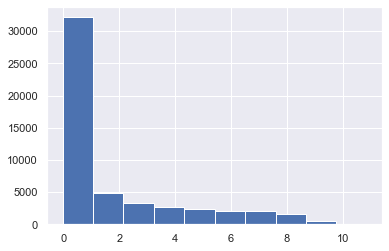

In [51]:
submission['UV'].hist()    

In [52]:
sub_abs = submission.abs()
sub_abs

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.0
1,202206010000,105,0.0
2,202206010000,108,0.0
3,202206010000,112,0.0
4,202206010000,115,0.0
...,...,...,...
51850,202206250000,146,0.0
51851,202206250000,152,0.0
51852,202206250000,156,0.0
51853,202206250000,159,0.0


<AxesSubplot:>

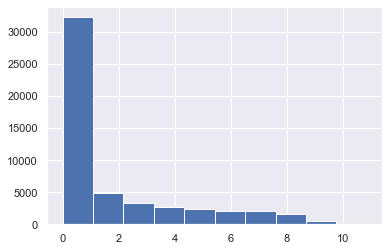

In [53]:
sub_abs['UV'].hist()    

In [54]:
sub_abs.to_csv('220224_abs_cloud_lgbm_optuna.csv', index=False)